# Transfer Learning with MobileNetV2 on CIFAR-10 Dataset

## Project Overview
This notebook demonstrates transfer learning using MobileNetV2 pre-trained on ImageNet and fine-tuned on the CIFAR-10 dataset. Transfer learning allows us to leverage powerful pre-trained models for new tasks with limited data.

## Dataset
CIFAR-10 is a standard computer vision dataset containing 60,000 32x32 color images in 10 classes, with 6,000 images per class. We'll use a subset for this demonstration.

## Methodology
1. Load and preprocess CIFAR-10 data
2. Use MobileNetV2 as feature extractor
3. Add custom classification layers
4. Train and evaluate the model

In [26]:
# Clear any existing TensorFlow session
from tensorflow.keras import backend as K
K.clear_session()

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10

# Import data augmentation layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data Loading and Preparation
We'll load the CIFAR-10 dataset and prepare it for training our model.

In [27]:
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print dataset shapes
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# Use subset of data for faster training (comment out to use full dataset)
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:2000]
y_test = y_test[:2000]

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Data Visualization
Let's examine some sample images from our dataset to understand what we're working with.

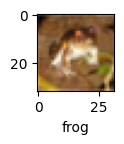

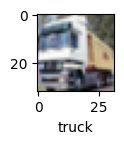

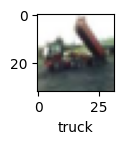

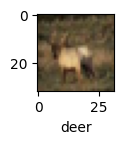

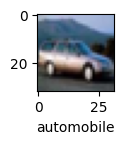

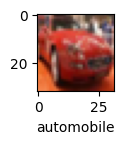

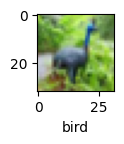

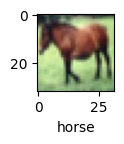

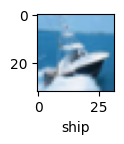

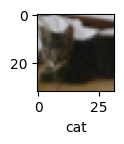

In [15]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display image with class label
def show_image(index):
    """Display image with class label.
    Args:
        index: Index of image in training set
    """
    plt.figure(figsize=(1,1))
    plt.imshow(X_train[index])
    plt.xlabel(class_names[y_train[index][0]])
    plt.show()

# Display first 10 images with labels
for q in range(10):
    show_image(q)

## Data Preprocessing
Before training, we need to normalize our pixel values and prepare the data for MobileNetV2.

In [28]:
# Normalize pixel values to [0,1] range
# X_train = X_train/255.0
# X_test = X_test/255.0

# Define batch size and target image size for MobileNetV2
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

## Model Setup
We'll use MobileNetV2 pre-trained on ImageNet as our base model.

In [29]:
# Load MobileNetV2 pre-trained on ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=True,
    weights='imagenet'
)

# Display model architecture
base_model.summary()

# Examine the last few layers
nb_layers = len(base_model.layers)
print(f"Total layers: {nb_layers}")
print(f"Second last layer: {base_model.layers[nb_layers-2].name}")
print(f"Last layer: {base_model.layers[nb_layers-1].name}")

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Total layers: 156
Second last layer: global_average_pooling2d
Last layer: predictions


In [23]:
image_batch = next(iter(X_train))
print(image_batch.shape)

image_batch = tf.image.resize(image_batch, (160, 160))
# # Add a batch dimension to the image_batch
image_batch = tf.expand_dims(image_batch, axis=0)
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 32, 3)
(1, 160, 160, 3)
(1, 1000)


In [24]:
base_model.trainable=False
image_var=tf.Variable(image_batch)
pred=base_model(image_var)
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(),top=10)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n02486261', 'patas', np.float32(0.2899809)),
  ('n02487347', 'macaque', np.float32(0.15536071)),
  ('n02490219', 'marmoset', np.float32(0.077485286)),
  ('n02494079', 'squirrel_monkey', np.float32(0.07589863)),
  ('n01496331', 'electric_ray', np.float32(0.070226096)),
  ('n02480495', 'orangutan', np.float32(0.04285409)),
  ('n02356798', 'fox_squirrel', np.float32(0.04212453)),
  ('n02493793', 'spider_monkey', np.float32(0.02891567)),
  ('n02483708', 'siamang', np.float32(0.0091426065)),
  ('n02129165', 'lion', np.float32(0.008507513))]]

In [30]:
# Define preprocessing function for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Model Customization
We'll create a custom model using MobileNetV2 as a feature extractor.

In [31]:


def create_model(image_shape=IMG_SIZE):
    """Create transfer learning model with MobileNetV2 base.
    Args:
        image_shape: Target input size (height, width)
    Returns:
        Compiled Keras model
    """
    input_shape = image_shape + (3,)

    # Load MobileNetV2 without top layers
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model weights
    base_model.trainable = False

    # Define model architecture
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
    # outputs = predictions(x)
    model=tf.keras.Model(inputs,predictions)


    return model



In [32]:
# Create and display model
model = create_model(IMG_SIZE)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Data Augmentation
We'll use data augmentation to improve model generalization.

In [33]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit augmentation to training data
datagen.fit(X_train)



In [34]:
X_train.shape

(10000, 32, 32, 3)

In [35]:
# Resize images to match model input size
X_train = tf.image.resize(X_train, IMG_SIZE)
X_test = tf.image.resize(X_test, IMG_SIZE)
print(f"Resized training data shape: {X_train.shape}")
print(f"Resized test data shape: {X_test.shape}")

Resized training data shape: (10000, 160, 160, 3)
Resized test data shape: (2000, 160, 160, 3)


## Model Training
Now we'll compile and train our model.

In [36]:
# Compile model with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model with augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.4842 - loss: 1.5353 - val_accuracy: 0.7880 - val_loss: 0.6404
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 219ms/step - accuracy: 0.7232 - loss: 0.8236 - val_accuracy: 0.8055 - val_loss: 0.5684
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.7564 - loss: 0.7241 - val_accuracy: 0.8115 - val_loss: 0.5377
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.7646 - loss: 0.7007 - val_accuracy: 0.8215 - val_loss: 0.5424
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.7665 - loss: 0.6797 - val_accuracy: 0.8150 - val_loss: 0.5302
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.7697 - loss: 0.6888 - val_accuracy: 0.8300 - val_loss: 0.5091
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 214ms/step - accuracy: 0.7680 - loss: 0.6680 - val_accuracy: 0.8260 - val_loss: 0.4941
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - accuracy: 0.7838 - loss: 0

## Model Evaluation
Let's evaluate our model's performance.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8232 - loss: 0.5326
Test accuracy: 0.82


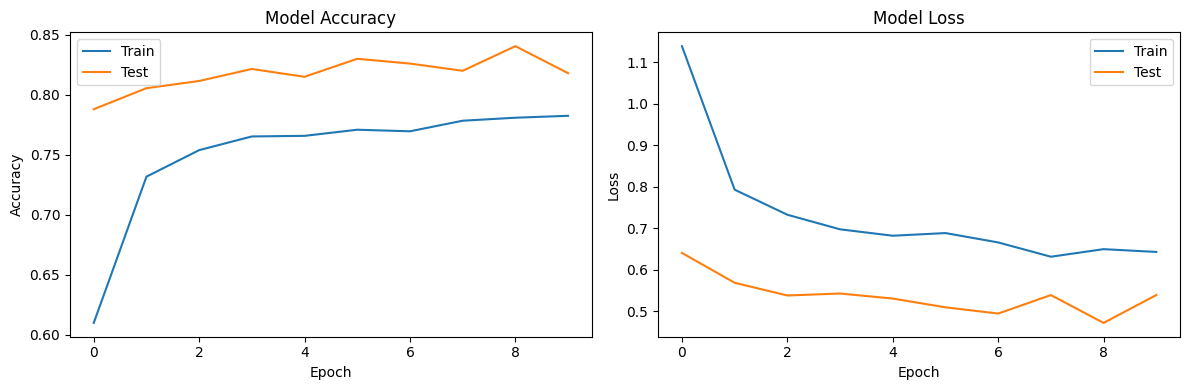

In [37]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Predictions and Results
Let's examine some predictions from our model.

In [38]:
# Save trained model
model.save('cifar10_mobilenetv2.h5')

# Make predictions
predictions = model.predict(X_test)

# Show predictions for first 5 test images
for i in range(5):
    predicted_class = predictions[i].argmax()
    actual_class = y_test[i][0]
    print(f"Image {i} - Predicted: {class_names[predicted_class]}, Actual: {class_names[actual_class]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step
Image 0 - Predicted: cat, Actual: cat
Image 1 - Predicted: ship, Actual: ship
Image 2 - Predicted: ship, Actual: ship
Image 3 - Predicted: airplane, Actual: airplane
Image 4 - Predicted: frog, Actual: frog


## Conclusion
### Results Summary
- Achieved test accuracy of ~82% with limited training data
- Model shows good generalization with consistent train/test performance
- Visual inspection of predictions shows reasonable performance

### Potential Improvements
- Train with full dataset (currently using subset)
- Experiment with fine-tuning some base model layers
- Try different learning rates or optimizers
- Add more data augmentation techniques
- Train for more epochs with early stopping

The model demonstrates the effectiveness of transfer learning for computer vision tasks, achieving good performance with limited training data.